In [1]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [2]:
RESULTS_DIR = "../eval-results"
N = 500
BUFFER_MS = 300

In [3]:
data = []

for r in glob.glob(os.path.join(RESULTS_DIR, "*")):
    fn, repeat, n, seed = os.path.basename(r).split("-")

    repeat = repeat[1:]
    seed = seed[1:]
    n = n[1:]

    if int(n) != N:
        continue

    power_logs = []
    function_logs = {}
    baseline = {}

    # check that the directory contains an eval.log
    if not os.path.exists(os.path.join(r, "eval.log")):
        print(f"Skipping {r} (incomplete)")
        continue

    with open(os.path.join(r, "measurement.log")) as f:
        for line in f:
            if not line.startswith("[measure]"):
                continue

            s = line.strip().split()

            if len(s) < 6:
                continue

            if s[4] == "power:":
                power_logs.append((float(s[-2][len("m=+"):]), float(s[-1])/1000))
                continue

            if s[4] == "baseline":
                if not s[5] == "startT:" and not s[5] == "endT:":
                    continue

                baseline[s[5][:-1]] = float(s[-1][len("m=+"):])
                continue

            if s[5] == "duration:" or s[5] == "input" or s[5] == "output" or s[5] == "start:" or s[5] == "end:" or s[5] == "startT:" or s[5] == "endT:":
                i = int(s[4][1:].split("/")[0])
                d = int(s[-2]) if not s[5] == "start:" and not s[5] == "end:" and not s[5] == "startT:" and not s[5] == "endT:" else float(s[-1][len("m=+"):])

                if i not in function_logs:
                    function_logs[i] = {}
                function_logs[i][s[5].split(":")[0]] = d
                continue

    # sort the power logs
    power_logs = sorted(power_logs, key=lambda x: x[0])

    data.append({
        "fn": fn,
        "repeat": int(repeat),
        "seed": int(seed),
        "n": int(n),
        "power_W": power_logs,
        "functions": function_logs,
        "baseline": baseline
    })

In [4]:
data

[{'fn': 'vessel',
  'repeat': 3,
  'seed': 201,
  'n': 500,
  'power_W': [(0.09443191, 2.646),
   (0.097633058, 2.626),
   (0.14533055, 2.599),
   (0.194883082, 2.619),
   (0.2462028, 2.616),
   (0.294091077, 2.614),
   (0.344225244, 2.585),
   (0.393680827, 2.595),
   (0.442924677, 2.595),
   (0.493029225, 2.6),
   (0.541970147, 2.611),
   (0.591847329, 2.61),
   (0.641336002, 2.596),
   (0.690867184, 2.614),
   (0.74055038, 2.6),
   (0.789428513, 2.595),
   (0.839575643, 2.585),
   (0.891301967, 2.621),
   (0.940426135, 2.59),
   (0.989959706, 2.6),
   (1.039279786, 2.6),
   (1.088559914, 2.656),
   (1.136884334, 2.595),
   (1.186057475, 2.61),
   (1.235800666, 2.6),
   (1.285225806, 2.589),
   (1.334785827, 2.601),
   (1.384827009, 2.595),
   (1.434112359, 2.605),
   (1.48333377, 2.595),
   (1.533013091, 2.595),
   (1.582589851, 2.61),
   (1.634281894, 2.595),
   (1.682761876, 2.599),
   (1.73253075, 2.589),
   (1.782693871, 2.6),
   (1.831633354, 2.604),
   (1.881498452, 2.6),
   (

In [5]:
def get_powerJ(power_W_logs, start, end):
    powerJ = 0

    for i in range(1, len(power_W_logs)-1):
        if power_W_logs[i][0] < start:
            continue

        if power_W_logs[i-1][0] > end:
            break

        # calculate the duration
        duration_start = power_W_logs[i-1][0]
        duration_end = power_W_logs[i][0]

        if duration_start < start:
            duration_start = start

        if duration_end > end:
            duration_end = end

        # calculate the power
        power = power_W_logs[i][1]
        duration_s = duration_end - duration_start

        # add to the total
        powerJ += power * duration_s

    return powerJ

In [6]:
baselines = []

for d in data:
    fn = d["fn"]
    repeat = d["repeat"]
    # print(fn, repeat)
    # print(d["baseline"])
    start = d["baseline"]["startT"]
    end = d["baseline"]["endT"]

    # go through the power logs and tally up the readings, multiply by the duration
    powerJ = get_powerJ(d["power_W"], start, end)
    W_baseline = powerJ / (end - start)

    baselines.append((fn, repeat, powerJ, W_baseline, end-start))

baseline_df = pd.DataFrame(baselines, columns=["fn", "repeat", "power_J", "W_baseline", "duration_s"])
baseline_df.to_csv("baseline.csv", index=False)

<Axes: xlabel='fn', ylabel='power_J'>

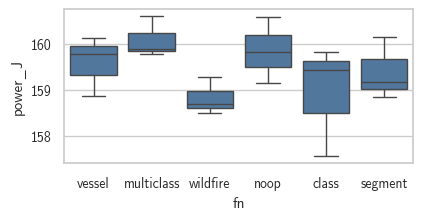

In [7]:
sns.boxplot(data=baseline_df, x="fn", y="power_J")

<Axes: xlabel='fn', ylabel='W_baseline'>

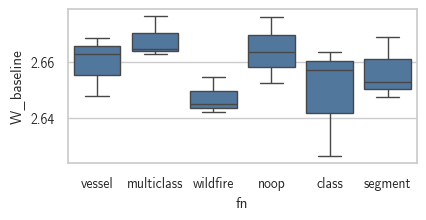

In [8]:
sns.boxplot(data=baseline_df, x="fn", y="W_baseline")

<Axes: xlabel='fn', ylabel='duration_s'>

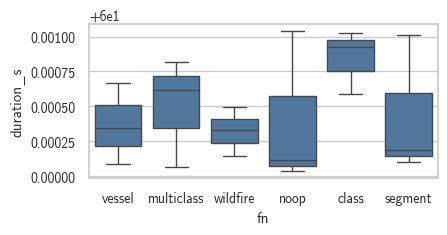

In [9]:
sns.boxplot(data=baseline_df, x="fn", y="duration_s")

In [10]:
def get_powerJ_mod(power_W_logs, start, end, startT, endT, buffer_ms):
    power_logs = []

    for i in range(1, len(power_W_logs)):
        if power_W_logs[i][0] < startT - buffer_ms:
            continue

        if power_W_logs[i-1][0] > endT + buffer_ms:
            break

        # calculate the duration
        duration = power_W_logs[i][0] - power_W_logs[i-1][0]

        # calculate the power
        power_logs.append((power_W_logs[i-1][1], duration))

    # sort by power
    power_logs = sorted(power_logs, key=lambda x: x[0], reverse=True)

    total_duration = end - start

    powerJ = 0
    i = 0
    while total_duration > 0:
        power = power_logs[i][0]
        duration = power_logs[i][1]

        powerJ += power * min(duration, total_duration)
        total_duration -= duration
        i += 1

    return powerJ

In [11]:
calls = []

for d in data:
    fn = d["fn"]
    repeat = d["repeat"]

    for i, f in d["functions"].items():
        powerJ = get_powerJ_mod(d["power_W"], f["start"], f["end"], f["startT"], f["endT"], BUFFER_MS)
        powerJ_nobaseline = powerJ - (baseline_df[(baseline_df["fn"] == fn) & (baseline_df["repeat"] == repeat)]["W_baseline"].values[0] * (f["end"] - f["start"]))
        did_something = f["output"] > 0
        calls.append((fn, repeat, i, f["end"]-f["start"], f["input"], f["output"], powerJ, powerJ_nobaseline, did_something))

call_df = pd.DataFrame(calls, columns=["fn", "repeat", "i", "duration_s", "input", "output", "power_J", "power_J_nobaseline", "did_something"])
call_df.to_csv("calls.csv", index=False)

<Axes: xlabel='power_J', ylabel='Proportion'>

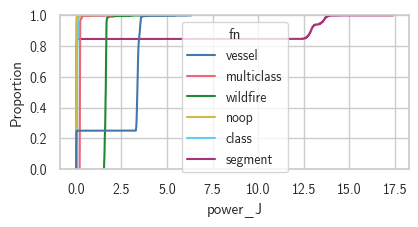

In [12]:
sns.ecdfplot(data=call_df, x="power_J", hue="fn")

<Axes: xlabel='power_J_nobaseline', ylabel='Proportion'>

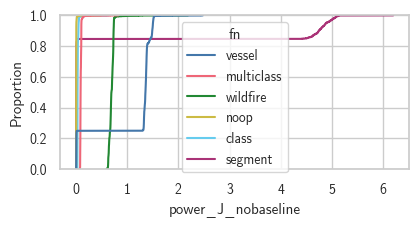

In [13]:
sns.ecdfplot(data=call_df, x="power_J_nobaseline", hue="fn")

<Axes: xlabel='power_J_nobaseline', ylabel='Proportion'>

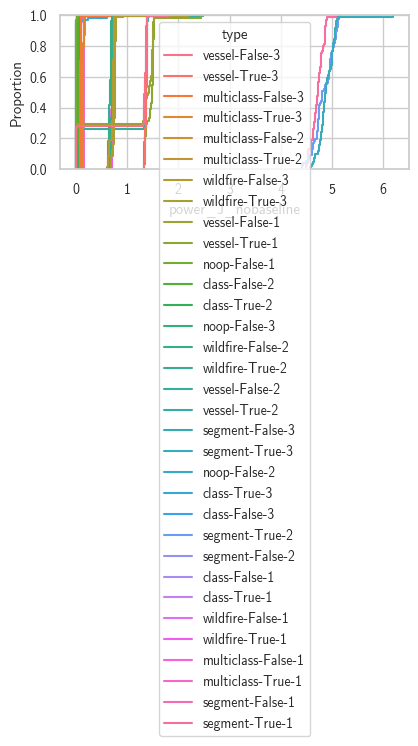

In [14]:
call_df["type"] = call_df["fn"] + "-" + call_df["did_something"].astype(str) + "-" + call_df["repeat"].astype(str)
sns.ecdfplot(data=call_df, x="power_J_nobaseline", hue="type")

<Axes: xlabel='duration_s', ylabel='Proportion'>

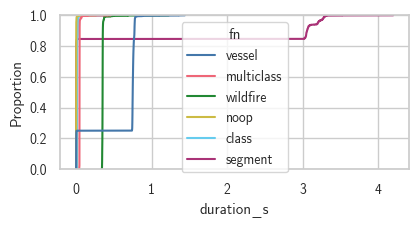

In [15]:
sns.ecdfplot(data=call_df, x="duration_s", hue="fn")

In [16]:
call_df["r"] = call_df["fn"] + "-" + call_df["repeat"].astype(str)

In [17]:
print("Ef (J)")
call_df["power_J_nobaseline"].groupby(call_df["r"]).mean()

Ef (J)


r
class-1         0.037563
class-2         0.040582
class-3         0.035694
multiclass-1    0.106757
multiclass-2    0.091457
multiclass-3    0.091806
noop-1          0.007175
noop-2          0.006787
noop-3          0.009721
segment-1       0.662148
segment-2       0.753902
segment-3       0.824608
vessel-1        1.073248
vessel-2        1.050502
vessel-3        1.015561
wildfire-1      0.707485
wildfire-2      0.666342
wildfire-3      0.718214
Name: power_J_nobaseline, dtype: float64

In [18]:
print("Cf")
(call_df["output"] / call_df["input"]).groupby(call_df["r"]).mean()

Cf


r
class-1         0.049158
class-2         0.050695
class-3         0.045318
multiclass-1    0.029486
multiclass-2    0.040543
multiclass-3    0.018429
noop-1          0.000000
noop-2          0.000000
noop-3          0.000000
segment-1       0.042574
segment-2       0.047414
segment-3       0.051212
vessel-1        0.023557
vessel-2        0.025867
vessel-3        0.020786
wildfire-1      0.011058
wildfire-2      0.027645
wildfire-3      0.022116
dtype: float64

In [19]:
print("Tf (s)")
call_df["duration_s"].groupby(call_df["r"]).mean()

Tf (s)


r
class-1         0.018569
class-2         0.018198
class-3         0.018474
multiclass-1    0.049532
multiclass-2    0.049518
multiclass-3    0.049213
noop-1          0.003740
noop-2          0.003838
noop-3          0.004535
segment-1       0.428516
segment-2       0.494445
segment-3       0.528234
vessel-1        0.561932
vessel-2        0.584578
vessel-3        0.566207
wildfire-1      0.356182
wildfire-2      0.352894
wildfire-3      0.355915
Name: duration_s, dtype: float64